In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.mul import UnaryMul
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
rng = "Sobol"

--- 0.2740025520324707 seconds ---
input error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0312, device='cuda:0') tensor(0.0273, device='cuda:0')
RMSE 0.007921697791410469
bias 1.640625e-05


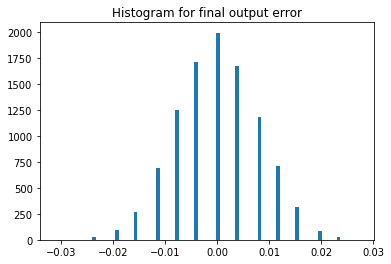

--- 0.13700008392333984 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.0117, device='cuda:0') tensor(0.0078, device='cuda:0')
RMSE 0.003127196493691474
bias -0.001449609375


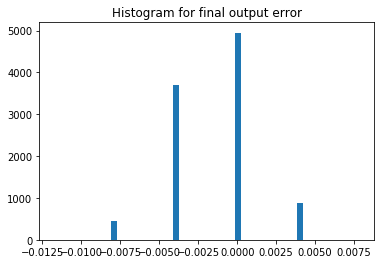

In [4]:
col = 10000
modes = ["bipolar", "unipolar"]
static = True
bitwidth = 8

for mode in modes:
    if mode is "unipolar":
        input_prob = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        iVec = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        input_prob = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        iVec = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_mul = UnaryMul(bitwidth,mode,static,input_prob).to(device)

    oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    iVecPE = ProgressiveError(iVec, mode=mode).to(device)
    oVecPE = ProgressiveError(oVec, mode=mode).to(device)

    iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
    iVecRNG = RNG(bitwidth, 1, rng)().to(device)
    iVecBS = BSGen(iVecSource, iVecRNG).to(device)

    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            iBS = iVecBS(i)
            iVecPE.Monitor(iBS)
            oVecU = dut_mul(iBS)   
            oVecPE.Monitor(oVecU)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", torch.min(iVecPE()[1]), torch.max(iVecPE()[1]))
        print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
        result_pe = oVecPE()[1].cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("bias", sum(result_pe)/len(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()